# Contextual online advertising with user data from U.S. Census

## Scenario
Consider an ad server that knows all of the information above about a user, except the education level. On the other hand, the ad network is managing ads that address a specific education level. For example, at any given time, the ad server has one ad that is targeting users with college education, one ad that is targeting users with elementary school education etc. If the target audience of the ad that is shown to a user matches the user's education level, there is a high probability of a click. If not, the probability of a click decreases gradually as the discrepancy between the target education level and the user's education level. In other words, the ad server is implicitly trying to predict users' education levels as close as possible.

In [ ]:
from collections import namedtuple
from numpy.random import uniform as U
import pandas as pd
import numpy as np
import io
import requests
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

## Data

We will use a dataset that was modified from the 1994 U.S. Census and adapt it to an online advertising setting. The dataset is known as "Census Income Dataset" and available at https://archive.ics.uci.edu/ml/datasets/Census+Income.

In this dataset we use the following information on the individuals participated in the census: Age, work class, education, marital status, occupation, relationship, race, gender, work hours per week, native country, and income level.

With that, let's discuss how to turn this data into an online advertising scenario.

In [ ]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
s=requests.get(url).content
names = ['age', 
           'workclass', 
           'fnlwgt', 
           'education',
           'education_num',
           'marital_status',
           'occupation',
           'relationship',
           'race',
           'gender',
           'capital_gain',
           'capital_loss',
           'hours_per_week',
           'native_country',
          'income']
usecols = ['age', 
           'workclass', 
           'education',
           'marital_status',
           'occupation',
           'relationship',
           'race',
           'gender',
           'hours_per_week',
           'native_country',
           'income']
df_census = pd.read_csv(io.StringIO(s.decode('utf-8')), 
                        sep=',',
                        skipinitialspace=True,
                        names=names,
                        header=None,
                        usecols=usecols)

Next, let's prepare the data set for our scenario.

In [ ]:
# Cleanup
df_census = df_census.replace('?', np.nan).dropna()
edu_map = {'Preschool': 'Elementary',
           '1st-4th': 'Elementary',
           '5th-6th': 'Elementary',
           '7th-8th': 'Elementary',
           '9th': 'Middle',
           '10th': 'Middle',
           '11th': 'Middle',
           '12th': 'Middle',
           'Some-college': 'Undergraduate',
           'Bachelors': 'Undergraduate',
           'Assoc-acdm': 'Undergraduate',
           'Assoc-voc': 'Undergraduate',
           'Prof-school': 'Graduate',
           'Masters': 'Graduate',
           'Doctorate': 'Graduate'}
           
for from_level, to_level in edu_map.items():
    df_census.education.replace(from_level, to_level, inplace=True)

# Convert raw data to processed data
context_cols = [c for c in usecols if c != 'education']
df_data = pd.concat([pd.get_dummies(df_census[context_cols]),
           df_census['education']], axis=1)

By doing this conversion at the beginning, we assume that we know all possible work class categories, native countries etc.

That's it! We have the data ready. Next, we implement a logic to simulate an ad click based on the actual education level of the user and the education level the ad displayed targets.

### Simulating ad clicks
In this example, the availability of ads is also random in addition to the ad clicks being stochastic. We need to come up with some logic to simulate this behavior. 

Let's start with determining the ad availability probabilities for each education category and implement the sampling of ads.

In [ ]:
def get_ad_inventory():
    ad_inv_prob = {'Elementary': 0.9, 
                   'Middle':  0.7, 
                   'HS-grad':  0.7, 
                   'Undergraduate':  0.9, 
                   'Graduate':  0.8}
    ad_inventory = []
    for level, prob in ad_inv_prob.items():
        if U() < prob:
            ad_inventory.append(level)
    # Make sure there are at least one ad
    if not ad_inventory:
        ad_inventory = get_ad_inventory()
    return ad_inventory

As mentioned above, the ad server will have at most one ad for each target group. We also ensure that there is at least one ad in the inventory.

Then, we define a function to generate a click probabilistically, where the likelihood of a click increases to the degree that the user's education level and the ad's target match.

In [ ]:
def get_ad_click_probs():
    base_prob = 0.8
    delta = 0.3
    ed_levels = {'Elementary': 1, 
                 'Middle':  2, 
                 'HS-grad':  3, 
                 'Undergraduate':  4, 
                 'Graduate':  5}
    ad_click_probs = {l1: {l2: max(0, base_prob - delta * abs(ed_levels[l1]- ed_levels[l2])) for l2 in ed_levels}
                           for l1 in ed_levels}
    return ad_click_probs

In [ ]:
def display_ad(ad_click_probs, user, ad):
    prob = ad_click_probs[ad][user['education']]
    click = 1 if U() < prob else 0
    return click

So, when an ad is shown to a user, if the ad's target matches the user's education level, there will be  chance of a click. This probability decreases by  for each level of mismatch. For example, a person with a high school diploma has a  chance to click on an ad that targets a user group of elementary school graduates (or college graduates). Note that this information is not known to the CB algorithm. It will be used only to simulate the clicks.

We have the problem set up. Next, we turn to implementing a CB model.

In [ ]:
def calc_regret(user, ad_inventory, ad_click_probs, ad_selected):
    this_p = 0
    max_p = 0
    for ad in ad_inventory:
        p = ad_click_probs[ad][user['education']]
        if ad == ad_selected:
            this_p = p
        if p > max_p:
            max_p = p
    regret = max_p - this_p
    return regret

In [ ]:
def get_model(n_input, dropout):
    inputs = keras.Input(shape=(n_input,))
    x = Dense(256, activation='relu')(inputs)
    if dropout > 0:
        x = Dropout(dropout)(x, training=True)
    x = Dense(256, activation='relu')(x)
    if dropout > 0:
        x = Dropout(dropout)(x, training=True)
    phat = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, phat)
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(),
                  metrics=[keras.metrics.binary_accuracy])
    return model

In [ ]:
def update_model(model, X, y):
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[2]))
    y = np.array(y).reshape(-1)
    model.fit(X, y, epochs=10)
    return model

In [ ]:
def ad_to_one_hot(ad):
    ed_levels = ['Elementary', 
                 'Middle', 
                 'HS-grad', 
                 'Undergraduate', 
                 'Graduate']
    ad_input = [0] * len(ed_levels)
    if ad in ed_levels:
        ad_input[ed_levels.index(ad)] = 1
    return ad_input

In [ ]:
def select_ad(model, context, ad_inventory):
    selected_ad = None
    selected_x = None
    max_action_val = 0
    for ad in ad_inventory:
        ad_x = ad_to_one_hot(ad)
        x = np.array(context + ad_x).reshape((1, -1))
        action_val_pred = model.predict(x)[0][0]
        if action_val_pred >= max_action_val:
            selected_ad = ad
            selected_x = x
            max_action_val = action_val_pred
    return selected_ad, selected_x

In [ ]:
def generate_user(df_data):
    user = df_data.sample(1)
    context = user.iloc[:, :-1].values.tolist()[0]
    return user.to_dict(orient='records')[0], context

In [ ]:
#collapse-hide
ad_click_probs = get_ad_click_probs()
df_cbandits = pd.DataFrame()
dropout_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.4]

for d in dropout_levels:
    print("Trying with dropout:", d)
    np.random.seed(0)
    context_n = df_data.shape[1] - 1
    ad_input_n = df_data.education.nunique()
    model = get_model(context_n + ad_input_n, 0.01)
    X = []
    y = []
    regret_vec = []
    total_regret = 0
    for i in range(5000):
        if i % 20 == 0:
            print("# of impressions:", i)
        user, context = generate_user(df_data)
        ad_inventory = get_ad_inventory()
        ad, x = select_ad(model, context, ad_inventory)
        click = display_ad(ad_click_probs, user, ad)
        regret = calc_regret(user, ad_inventory, ad_click_probs, ad)
        total_regret += regret
        regret_vec.append(total_regret)
        X.append(x)
        y.append(click)
        if (i + 1) % 500 == 0:
            print('Updating the model at', i+1)
            model = update_model(model, X, y)
            X = []
            y = []
            
    df_cbandits['dropout: '+str(d)] = regret_vec

Trying with dropout: 0
# of impressions: 0
# of impressions: 20
# of impressions: 40
# of impressions: 60
# of impressions: 80
# of impressions: 100
# of impressions: 120
# of impressions: 140
# of impressions: 160
# of impressions: 180
# of impressions: 200
# of impressions: 220
# of impressions: 240
# of impressions: 260
# of impressions: 280
# of impressions: 300
# of impressions: 320
# of impressions: 340
# of impressions: 360
# of impressions: 380
# of impressions: 400
# of impressions: 420
# of impressions: 440
# of impressions: 460
# of impressions: 480
Updating the model at 500
Epoch 1/10
16/16 [==============================] - 1s 3ms/step - loss: 0.8424 - binary_accuracy: 0.5600
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7275 - binary_accuracy: 0.5700
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6772 - binary_accuracy: 0.6280
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6462 - binary_accu

In [ ]:
df_cbandits.iplot(dash = ['dash', 'solid', 'dashdot', 
                          'dot', 'longdash', 'longdashdot'],
                  xTitle='Impressions', 
                  yTitle='Cumulative Regret')

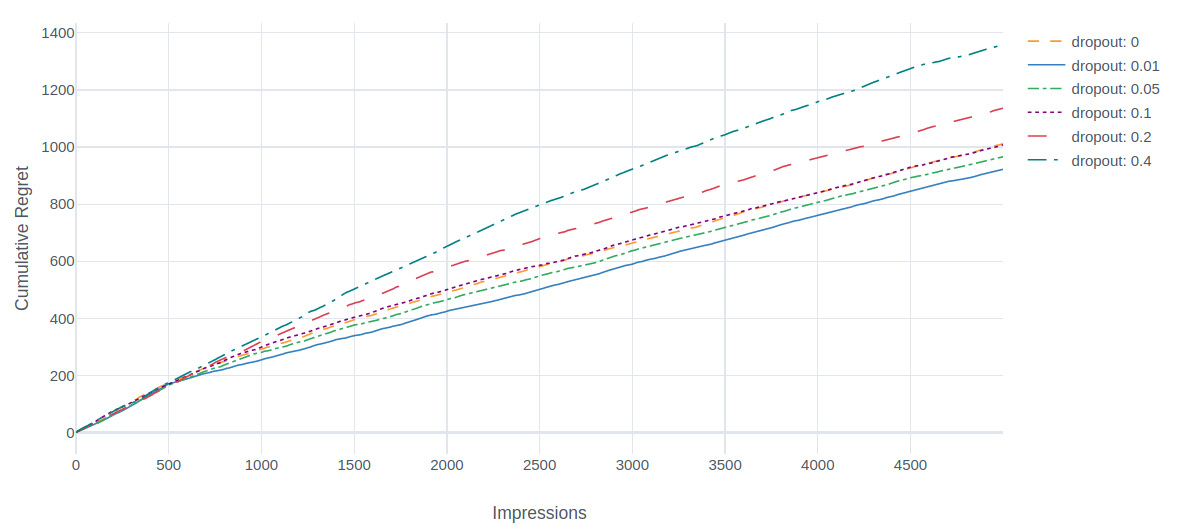

*Comparison of cumulative regret with various dropout rates*

The results on the above figure show that our bandit models learn after some observations how to select the ads given the user characteristics. As various dropout rates have led to different algorithm performances, an important question again becomes how to select the dropout rate. One obvious answer is to try different rates over time identify what works the best in similar online advertising problems. This approach usually works if the business has to solve similar problems again and again over a long time period. A better approach though is to learn the optimal dropout rate.